In [1]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import global_visualize_wo_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_regularization
from gaminet.utils import plot_trajectory

In [2]:
def load_fico(path="./", missing_strategy="drop"):
    data = pd.read_csv(path + "/fico/heloc_dataset_v1.csv")
    meta_info = json.load(open(path + "/fico/data_types.json"))
    meta_info.pop("RiskPerformance")

    ## remove samples with all the values == -9
    rem_sample_idx = np.where(np.sum(data.values[:, 1:].astype(float) == -9, 1) == 23)[0]
    keep_sample_idx = np.where(np.sum(data.values[:, 1:].astype(float) == -9, 1) < 23)[0]
    data_rem9 = data.iloc[keep_sample_idx]

    ## dummy for -7, -8, -9
    sample_size = data_rem9.shape[0]
    dummy_data = pd.DataFrame(index = data_rem9.index)
    for i in np.where(np.sum(data_rem9 == -9, 0).values > 0)[0]:
        temp = np.zeros(sample_size)
        temp[np.where(data_rem9.iloc[:, i].values == -9)[0]] = 1
        dummy_data[data_rem9.columns[i] + "_D-9"] = temp
        meta_info.update({data_rem9.columns[i] + "_D-9":{"type": "categorical"}})

    for i in np.where(np.sum(data_rem9 == -8, 0).values > 0)[0]:
        temp = np.zeros(sample_size)
        temp[np.where(data_rem9.iloc[:, i].values == -8)[0]] = 1
        dummy_data[data_rem9.columns[i] + "_D-8"] = temp
        meta_info.update({data_rem9.columns[i] + "_D-8":{"type": "categorical"}})

    for i in np.where(np.sum(data_rem9 == -7, 0).values > 0)[0]:
        temp = np.zeros(sample_size)
        temp[np.where(data_rem9.iloc[:, i].values == -7)[0]] = 1
        dummy_data[data_rem9.columns[i] + "_D-7"] = temp
        meta_info.update({data_rem9.columns[i] + "_D-7":{"type": "categorical"}})

    meta_info.update({"RiskPerformance":{"type": "target"}})
    final_data = pd.concat([data_rem9.replace(-9, 0).replace(-8, 0).replace(-7, 0), dummy_data], 1)
    x, y = final_data.iloc[:,1:].values, final_data.iloc[:,[0]].values
    return x, y, "Classification", meta_info

def load_classification_data(name):
    data_path = '.'
    func_dict = {'fico':load_fico}
    def wrapper(random_state):
        function_name_ = func_dict[name]
        x, y, task_type, meta_info = function_name_(data_path, missing_strategy="impute")
        xx = np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)
        for i, (key, item) in enumerate(meta_info.items()):
            if item['type'] == 'target':
                enc = OrdinalEncoder()
                enc.fit(y)
                y = enc.transform(y)
                meta_info[key]['values'] = enc.categories_[0].tolist()
            elif item['type'] == 'categorical':
                enc = OrdinalEncoder()
                xx[:,[i]] = enc.fit_transform(x[:,[i]])
                meta_info[key]['values'] = []
                for item in enc.categories_[0].tolist():
                    try:
                        if item == int(item):
                            meta_info[key]['values'].append(str(int(item)))
                        else:
                            meta_info[key]['values'].append(str(item))
                    except ValueError:
                        meta_info[key]['values'].append(str(item))
            else:
                sx = MinMaxScaler((0, 1))
                xx[:,[i]] = sx.fit_transform(x[:,[i]])
                meta_info[key]['scaler'] = sx
        train_x, test_x, train_y, test_y = train_test_split(xx.astype(np.float32), y, stratify=y,
                                                            test_size=0.2, random_state=random_state)
        return train_x, test_x, train_y, test_y, task_type, meta_info
    return wrapper

In [3]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def auc(label, pred, scaler=None):
    return roc_auc_score(label, pred)

get_metric = metric_wrapper(auc, None)

In [4]:
random_state = 0
data_loader = load_classification_data("fico")
train_x, test_x, train_y, test_y, task_type, meta_info = data_loader(random_state)

In [5]:
meta_info.keys()

dict_keys(['ExternalRiskEstimate', 'MSinceOldestTradeOpen', 'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades', 'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec', 'PercentTradesNeverDelq', 'MSinceMostRecentDelq', 'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades', 'NumTradesOpeninLast12M', 'PercentInstallTrades', 'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days', 'NetFractionRevolvingBurden', 'NetFractionInstallBurden', 'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance', 'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance', 'ExternalRiskEstimate_D-9', 'MSinceOldestTradeOpen_D-8', 'MSinceMostRecentDelq_D-8', 'MSinceMostRecentInqexcl7days_D-8', 'NetFractionRevolvingBurden_D-8', 'NetFractionInstallBurden_D-8', 'NumRevolvingTradesWBalance_D-8', 'NumInstallTradesWBalance_D-8', 'NumBank2NatlTradesWHighUtilization_D-8', 'PercentTradesWBalance_D-8', 'MSinceMostRecentDelq_D-7', 'MSinceMostRecentInqexcl7days_D-7', 'Risk

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.66203, val loss: 0.66206
Main effects training epoch: 2, train loss: 0.65206, val loss: 0.65190
Main effects training epoch: 3, train loss: 0.63601, val loss: 0.63571
Main effects training epoch: 4, train loss: 0.61845, val loss: 0.61814
Main effects training epoch: 5, train loss: 0.60469, val loss: 0.60444
Main effects training epoch: 6, train loss: 0.59327, val loss: 0.59207
Main effects training epoch: 7, train loss: 0.58692, val loss: 0.58610
Main effects training epoch: 8, train loss: 0.57911, val loss: 0.57790
Main effects training epoch: 9, train loss: 0.57309, val loss: 0.57155
Main effects training epoch: 10, train loss: 0.56700, val loss: 0.56504
Main effects training epoch: 11, train loss: 0.56132, val loss: 0.55944
Main effects training epoch: 12, train loss: 0.55675, val loss: 0.55405
Main effects training e

Interaction training epoch: 5, train loss: 0.52960, val loss: 0.53589
Interaction training epoch: 6, train loss: 0.52954, val loss: 0.53590
Interaction training epoch: 7, train loss: 0.52940, val loss: 0.53582
Interaction training epoch: 8, train loss: 0.52941, val loss: 0.53589
Interaction training epoch: 9, train loss: 0.52937, val loss: 0.53594
Interaction training epoch: 10, train loss: 0.52933, val loss: 0.53597
Interaction training epoch: 11, train loss: 0.52932, val loss: 0.53595
Interaction training epoch: 12, train loss: 0.52930, val loss: 0.53600
Interaction training epoch: 13, train loss: 0.52926, val loss: 0.53604
Interaction training epoch: 14, train loss: 0.52926, val loss: 0.53603
Interaction training epoch: 15, train loss: 0.52924, val loss: 0.53616
Interaction training epoch: 16, train loss: 0.52912, val loss: 0.53606
Interaction training epoch: 17, train loss: 0.52920, val loss: 0.53604
Interaction training epoch: 18, train loss: 0.52915, val loss: 0.53607
Interaction

Fine tuning epoch: 70, train loss: 0.52992, val loss: 0.53553
Fine tuning epoch: 71, train loss: 0.52991, val loss: 0.53555
Fine tuning epoch: 72, train loss: 0.52990, val loss: 0.53554
Fine tuning epoch: 73, train loss: 0.52988, val loss: 0.53552
Fine tuning epoch: 74, train loss: 0.52986, val loss: 0.53551
Fine tuning epoch: 75, train loss: 0.52985, val loss: 0.53553
Fine tuning epoch: 76, train loss: 0.52984, val loss: 0.53551
Fine tuning epoch: 77, train loss: 0.52983, val loss: 0.53553
Fine tuning epoch: 78, train loss: 0.52983, val loss: 0.53553
Fine tuning epoch: 79, train loss: 0.52981, val loss: 0.53548
Fine tuning epoch: 80, train loss: 0.52980, val loss: 0.53552
Fine tuning epoch: 81, train loss: 0.52979, val loss: 0.53552
Fine tuning epoch: 82, train loss: 0.52978, val loss: 0.53552
Fine tuning epoch: 83, train loss: 0.52977, val loss: 0.53548
Fine tuning epoch: 84, train loss: 0.52975, val loss: 0.53552
Fine tuning epoch: 85, train loss: 0.52975, val loss: 0.53554
Fine tun

Fine tuning epoch: 201, train loss: 0.52917, val loss: 0.53549
Fine tuning epoch: 202, train loss: 0.52917, val loss: 0.53545
Fine tuning epoch: 203, train loss: 0.52916, val loss: 0.53546
Fine tuning epoch: 204, train loss: 0.52916, val loss: 0.53548
Fine tuning epoch: 205, train loss: 0.52918, val loss: 0.53550
Fine tuning epoch: 206, train loss: 0.52915, val loss: 0.53548
Fine tuning epoch: 207, train loss: 0.52915, val loss: 0.53549
Fine tuning epoch: 208, train loss: 0.52915, val loss: 0.53546
Fine tuning epoch: 209, train loss: 0.52915, val loss: 0.53548
Fine tuning epoch: 210, train loss: 0.52915, val loss: 0.53546
Fine tuning epoch: 211, train loss: 0.52914, val loss: 0.53546
Fine tuning epoch: 212, train loss: 0.52914, val loss: 0.53547
Fine tuning epoch: 213, train loss: 0.52913, val loss: 0.53545
Fine tuning epoch: 214, train loss: 0.52916, val loss: 0.53553
Early stop at epoch 214, with validation loss: 0.53553
####################GAMI-Net training finished.################

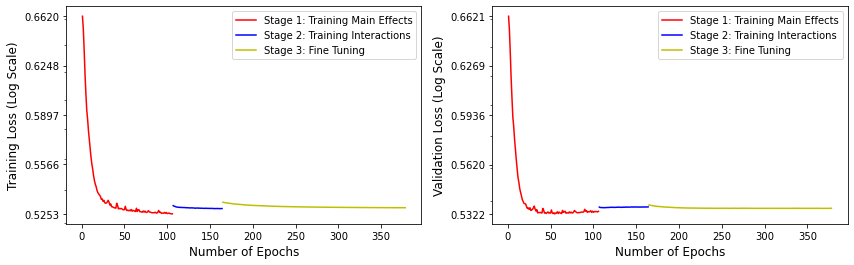

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


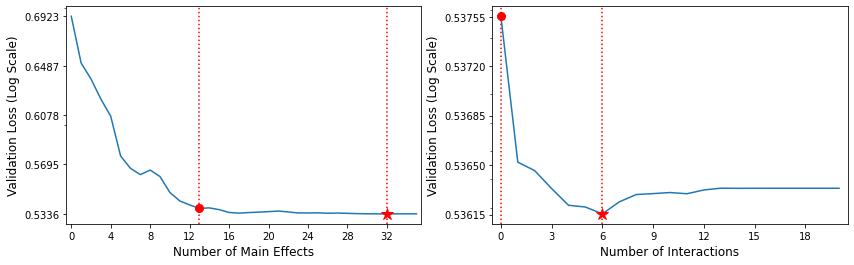

In [6]:
folder = "./results/"
if not os.path.exists(folder):
    os.makedirs(folder)

model_fico = GAMINet(meta_info={"X" + str(i + 1):item for i, item in enumerate(meta_info.values())}, interact_num=20,
            interact_arch=[40] * 5, subnet_arch=[40] * 5, 
            batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
            main_effect_epochs=5000, interaction_epochs=5000, tuning_epochs=500, 
            lr_bp=[0.001, 0.001, 0.0001], early_stop_thres=[50, 50, 50],
            heredity=True, loss_threshold=0.01, reg_clarity=0.1,
            mono_increasing_list=[0, 1, 2, 3, 4, 7, 8, 9, 10, 14],
            mono_decreasing_list=[5, 6, 12, 15, 16, 17, 18, 21],
            verbose=True, val_ratio=0.2, random_state=0)
model_fico.fit(train_x, train_y)
data_dict_logs = model_fico.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=folder, name="fico_traj", save_png=True, save_eps=True)
plot_regularization(data_dict_logs, folder=folder, name="fico_regu", save_png=True, save_eps=True)

In [7]:
pred_train = model_fico.predict(train_x)
pred_test = model_fico.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[0.81266 0.81086]


Global Interpretation

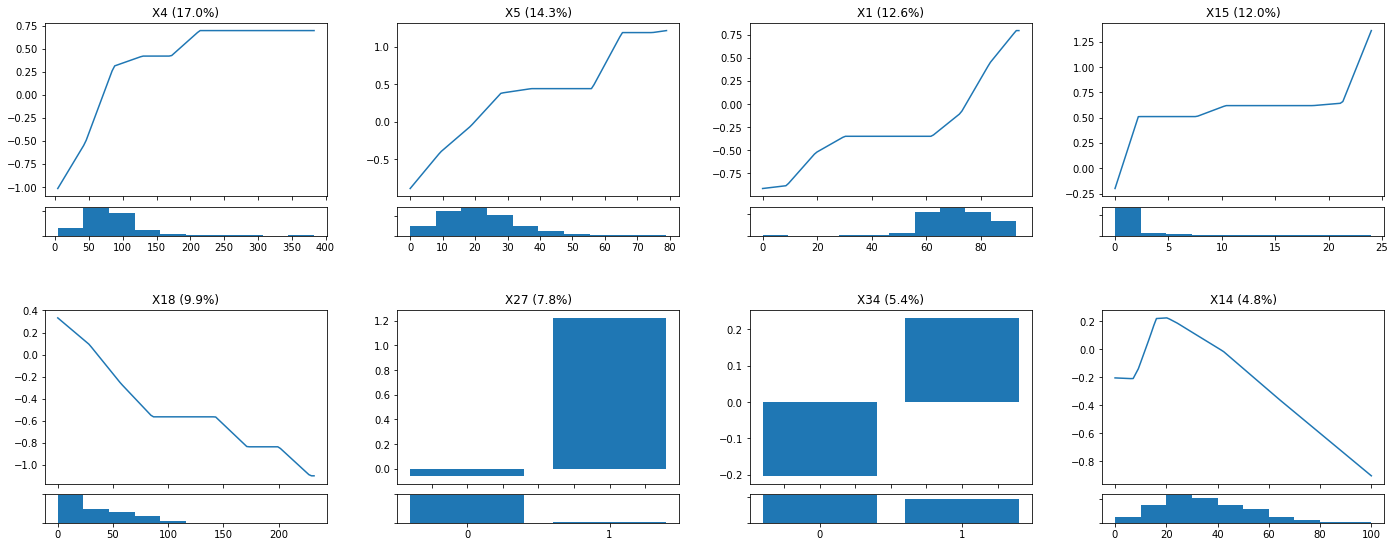

In [8]:
data_dict_global = model_fico.global_explain(save_dict=True, folder=folder, name="fico_global")
global_visualize_density(data_dict_global, folder=folder, name="fico_global",  #11, 13, 19, 20
                         main_effect_num=8, interaction_num=4, cols_per_row=4, save_png=True, save_eps=True)

Feature Importance

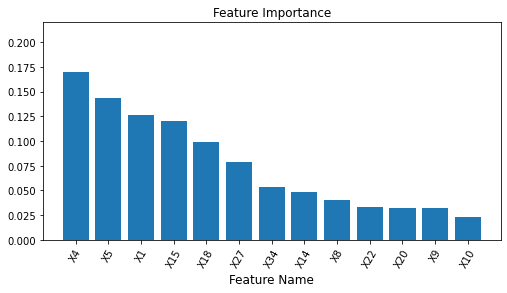

In [9]:
feature_importance_visualize(data_dict_global)

Interpret the prediction of a test sample

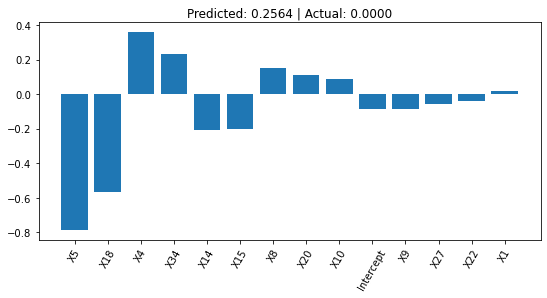

In [10]:
data_dict_local = model_fico.local_explain(test_x[[0]], test_y[[0]], save_dict=False)
local_visualize(data_dict_local[0], save_png=False)